# BPI Challenge 2012: Financial Log Analysis

This notebook performs a process mining analysis on the BPI Challenge 2012 event log, which details a loan application process at a Dutch financial institute.  
The analysis involves several stages:
1.  **Initial Exploration**: Loading the data and gathering basic statistics.
2.  **Data Cleaning**: Filtering incomplete cases and removing redundant events.
3.  **Log Segmentation**: Splitting the log based on the final outcome of the application (Approved, Declined, Cancelled).
4.  **Comparative KPI Analysis**: Calculating and comparing performance indicators for each outcome segment.
5.  **Direct-Follows Analysis**: Examining common process flows and rework loops within each segment.

## 1. Initial Exploration and Data Loading

### Import Libraries

In [17]:
import pm4py
from pm4py.objects.log.util import sorting

### Load the Event Log

We load the BPI 2012 financial log from an XES file.

In [18]:
file_path = './data/financial_log.xes'

log = pm4py.read_xes(file_path)

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

### Basic Log Statistics

In [19]:
print("\n--- Basic Log Statistics ---")
num_cases = len(log)
num_events = sum(len(case) for case in log)
print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")


--- Basic Log Statistics ---
Number of cases: 262200
Number of events: 103


### Timeframe of the Log

In [20]:
# Ensure the log is sorted by timestamp before getting start/end times.
log = sorting.sort_timestamp_log(log)

start_timestamp = log[0][0]['time:timestamp']
end_timestamp = log[-1][-1]['time:timestamp']
print(f"\nLog starts at: {start_timestamp}")
print(f"Log ends at: {end_timestamp}")



Log starts at: 2011-10-01 00:38:44.546000+00:00
Log ends at: 2012-03-01 09:27:41.325000+00:00


### Process Variants

In [21]:
variants = pm4py.get_variants_as_tuples(log)
num_variants = len(variants)
print(f"\nNumber of process variants: {num_variants}")


Number of process variants: 4366


### Unique Activities

In [22]:
activities = pm4py.get_event_attribute_values(log, "concept:name")
print(f"\n--- List of Unique Activities (Total: {len(activities)}) ---")

for activity in sorted(activities.keys()):
    print(f"- {activity}")


--- List of Unique Activities (Total: 24) ---
- A_ACCEPTED
- A_ACTIVATED
- A_APPROVED
- A_CANCELLED
- A_DECLINED
- A_FINALIZED
- A_PARTLYSUBMITTED
- A_PREACCEPTED
- A_REGISTERED
- A_SUBMITTED
- O_ACCEPTED
- O_CANCELLED
- O_CREATED
- O_DECLINED
- O_SELECTED
- O_SENT
- O_SENT_BACK
- W_Afhandelen leads
- W_Beoordelen fraude
- W_Completeren aanvraag
- W_Nabellen incomplete dossiers
- W_Nabellen offertes
- W_Valideren aanvraag
- W_Wijzigen contractgegevens


### Case Attributes

In [23]:
# We'll check the attributes of the first case as an example
case_attributes = log[0].attributes
print("\n--- Case Attributes (from first case) ---")
for attr, value in case_attributes.items():
    print(f"- {attr}: {value}")


--- Case Attributes (from first case) ---
- REG_DATE: 2011-10-01 00:38:44.546000+00:00
- concept:name: 173688
- AMOUNT_REQ: 20000


### Example Case Structure

In [24]:
print("\n--- Structure of the First Case ---")

case_id = log[0].attributes['concept:name']
print(f"Case ID: {case_id}")
print("Events in the first case:")
for i, event in enumerate(log[0]):
    event_number = i + 1
    print(f"  Event {event_number}:")
    # Convert event to dictionary for easy iteration
    event_dict = dict(event)
    for key, value in event_dict.items():
        print(f"    - {key}: {key} = {value}")
    if event_number == 3: # Print first 3 events for brevity
        print("    - ...")
        break



--- Structure of the First Case ---
Case ID: 173688
Events in the first case:
  Event 1:
    - org:resource: org:resource = 112
    - lifecycle:transition: lifecycle:transition = COMPLETE
    - concept:name: concept:name = A_SUBMITTED
    - time:timestamp: time:timestamp = 2011-10-01 00:38:44.546000+00:00
  Event 2:
    - org:resource: org:resource = 112
    - lifecycle:transition: lifecycle:transition = COMPLETE
    - concept:name: concept:name = A_PARTLYSUBMITTED
    - time:timestamp: time:timestamp = 2011-10-01 00:38:44.880000+00:00
  Event 3:
    - org:resource: org:resource = 112
    - lifecycle:transition: lifecycle:transition = COMPLETE
    - concept:name: concept:name = A_PREACCEPTED
    - time:timestamp: time:timestamp = 2011-10-01 00:39:37.906000+00:00
    - ...


## 2. Data Cleaning and Preprocessing

Before analysis, we need to perform two cleaning steps:
1.  Filter out incomplete cases that don't have a definitive final outcome (Approved, Declined, or Cancelled).
2.  Remove a redundant activity, `A_PARTLYSUBMITTED`, which occurs immediately after `A_SUBMITTED` and adds little value to the process analysis.

In [25]:
from pm4py.objects.log.obj import EventLog, Trace
import pm4py 

# We start with the 'log' object from Cell 1
print("--- Starting Data Cleaning and Filtering ---")
print(f"Original log stats: {len(log)} cases, {sum(len(case) for case in log)} events")

--- Starting Data Cleaning and Filtering ---
Original log stats: 13087 cases, 262200 events


### Filter 1: Keep Cases with a Final Outcome

We create a new log containing only traces that include one of the defined final activities: 'A_DECLINED', 'A_CANCELLED', or 'A_APPROVED'.

In [26]:
final_activities = {'A_DECLINED', 'A_CANCELLED', 'A_APPROVED'}

filtered_traces_list = [trace for trace in log if any(event['concept:name'] in final_activities for event in trace)]

log_filtered_outcome = EventLog(filtered_traces_list,
                                attributes=log.attributes,
                                extensions=log.extensions,
                                classifiers=log.classifiers,
                                properties=log.properties)

cases_removed = len(log) - len(log_filtered_outcome)

print("\n--- After filtering for cases with a final outcome ---")
print(f"Filtered log stats: {len(log_filtered_outcome)} cases, {sum(len(case) for case in log_filtered_outcome)} events")
print(f"Removed {cases_removed} incomplete cases.")


--- After filtering for cases with a final outcome ---
Filtered log stats: 12688 cases, 249451 events
Removed 399 incomplete cases.


### Filter 2: Remove Redundant 'A_PARTLYSUBMITTED' Events

To simplify the process model, we remove the `A_PARTLYSUBMITTED` event from every trace. This requires creating new `Trace` objects, as they are immutable.

In [35]:
final_traces_list = []

for trace in log_filtered_outcome:
    events_for_new_trace = [event for event in trace if event['concept:name'] != 'A_PARTLYSUBMITTED']
    
    new_trace = Trace(events_for_new_trace, attributes=trace.attributes)

    final_traces_list.append(new_trace)

cleaned_log = EventLog(final_traces_list,
                       attributes=log_filtered_outcome.attributes,
                       extensions=log_filtered_outcome.extensions,
                       classifiers=log_filtered_outcome.classifiers,
                       properties=log_filtered_outcome.properties)

events_removed = sum(len(case) for case in log_filtered_outcome) - sum(len(case) for case in cleaned_log)

print("\n--- After removing redundant 'A_PARTLYSUBMITTED' events ---")
print(f"Final cleaned log stats: {len(cleaned_log)} cases, {sum(len(case) for case in cleaned_log)} events")
print(f"Removed {events_removed} redundant events.")


--- After removing redundant 'A_PARTLYSUBMITTED' events ---
Final cleaned log stats: 12688 cases, 236763 events
Removed 12688 redundant events.


### Verify Cleaned Log

Finally, we verify the activities present in the cleaned log to confirm the redundant event has been removed.

In [28]:
final_activities_list = pm4py.get_event_attribute_values(cleaned_log, "concept:name")
print(f"\n--- Unique Activities in Cleaned Log (Total: {len(final_activities_list)}) ---")
for activity in sorted(final_activities_list.keys()):
    print(f"- {activity}")



--- Unique Activities in Cleaned Log (Total: 23) ---
- A_ACCEPTED
- A_ACTIVATED
- A_APPROVED
- A_CANCELLED
- A_DECLINED
- A_FINALIZED
- A_PREACCEPTED
- A_REGISTERED
- A_SUBMITTED
- O_ACCEPTED
- O_CANCELLED
- O_CREATED
- O_DECLINED
- O_SELECTED
- O_SENT
- O_SENT_BACK
- W_Afhandelen leads
- W_Beoordelen fraude
- W_Completeren aanvraag
- W_Nabellen incomplete dossiers
- W_Nabellen offertes
- W_Valideren aanvraag
- W_Wijzigen contractgegevens


## 3. Log Segmentation by Outcome

To compare the behavior of different process outcomes, we need to segment the cleaned log into three separate logs based on their final status: Approved, Declined, and Cancelled.  

### Define Segmentation Logic

We will classify each case based on a priority order: `A_APPROVED` > `A_DECLINED` > `A_CANCELLED`.  
This means a case with both `A_DECLINED` and `A_CANCELLED` will be categorized as 'Declined'.

### Classify and Segment Traces


In [29]:
from pm4py.objects.log.obj import EventLog

approved_traces = []
declined_traces = []
cancelled_traces = []

for trace in cleaned_log:
    activities_in_trace = {event['concept:name'] for event in trace}

    if 'A_APPROVED' in activities_in_trace:
        approved_traces.append(trace)
    elif 'A_DECLINED' in activities_in_trace:
        declined_traces.append(trace)
    elif 'A_CANCELLED' in activities_in_trace:
        cancelled_traces.append(trace)

### Create New Event Log Objects

In [30]:
log_approved = EventLog(approved_traces,
                        attributes=cleaned_log.attributes,
                        extensions=cleaned_log.extensions,
                        classifiers=cleaned_log.classifiers,
                        properties=cleaned_log.properties)

log_declined = EventLog(declined_traces,
                        attributes=cleaned_log.attributes,
                        extensions=cleaned_log.extensions,
                        classifiers=cleaned_log.classifiers,
                        properties=cleaned_log.properties)

log_cancelled = EventLog(cancelled_traces,
                         attributes=cleaned_log.attributes,
                         extensions=cleaned_log.extensions,
                         classifiers=cleaned_log.classifiers,
                         properties=cleaned_log.properties)

### Segmentation Statistics and Verification

We print the statistics for each new log and verify that all cases from the cleaned log have been assigned to a segment.

In [31]:
# Approved Cases
num_approved = len(log_approved)
events_approved = sum(len(case) for case in log_approved)
avg_events_approved = events_approved / num_approved if num_approved > 0 else 0
print(f"\nSegment: APPROVED")
print(f"Number of cases: {num_approved}")
print(f"Number of events: {events_approved}")
print(f"Average events per case: {avg_events_approved:.2f}")

# Declined Cases
num_declined = len(log_declined)
events_declined = sum(len(case) for case in log_declined)
avg_events_declined = events_declined / num_declined if num_declined > 0 else 0
print(f"\nSegment: DECLINED")
print(f"Number of cases: {num_declined}")
print(f"Number of events: {events_declined}")
print(f"Average events per case: {avg_events_declined:.2f}")

# Cancelled Cases
num_cancelled = len(log_cancelled)
events_cancelled = sum(len(case) for case in log_cancelled)
avg_events_cancelled = events_cancelled / num_cancelled if num_cancelled > 0 else 0
print(f"\nSegment: CANCELLED")
print(f"Number of cases: {num_cancelled}")
print(f"Number of events: {events_cancelled}")
print(f"Average events per case: {avg_events_cancelled:.2f}")

# --- 6. Verification ---
total_segmented_cases = num_approved + num_declined + num_cancelled
print("\n--- Verification ---")
print(f"Total cases in cleaned log: {len(cleaned_log)}")
print(f"Total cases segmented:      {total_segmented_cases}")

if len(cleaned_log) == total_segmented_cases:
    print("Verification Success: All cases have been segmented.")
else:
    print("Verification Error: Mismatch in case counts.")


Segment: APPROVED
Number of cases: 2246
Number of events: 97679
Average events per case: 43.49

Segment: DECLINED
Number of cases: 7635
Number of events: 62797
Average events per case: 8.22

Segment: CANCELLED
Number of cases: 2807
Number of events: 76287
Average events per case: 27.18

--- Verification ---
Total cases in cleaned log: 12688
Total cases segmented:      12688
Verification Success: All cases have been segmented.


## 4. Comparative Performance Analysis (KPIs)

Now that we have segmented logs, we can compare their performance based on key metrics.

### Define KPI Calculation Function

This function calculates the following KPIs for a given event log:
- Average case duration in days.
- Average requested loan amount.
- Average number of work items (activities starting with 'W_').
- Total rework activities.

In [32]:
import pandas as pd
import numpy as np

def calculate_kpis(_log, segment_name):

    durations = []
    for trace in _log:
        sorted_trace = sorted(trace, key=lambda _event: _event['time:timestamp'])
        duration_seconds = (sorted_trace[-1]['time:timestamp'] - sorted_trace[0]['time:timestamp']).total_seconds()
        durations.append(duration_seconds / (24 * 3600)) # Convert to days
        
    
    # Calculate requested loan amounts
    amounts = [float(trace.attributes['AMOUNT_REQ']) for trace in _log]
    
    # Calculate rework (number of 'W_' activities)
    rework_counts = []
    total_rework_activities = 0
    for trace in _log:
        work_item_count = sum(1 for _event in trace if _event['concept:name'].startswith('W_'))
        rework_counts.append(work_item_count)
        total_rework_activities += work_item_count

    # Create a dictionary with the results
    kpi_results = {
        "Segment": segment_name,
        "Percentage of a whole": len(_log) / total_segmented_cases,
        "Number of Cases": len(_log),
        "Avg. Duration (Days)": np.mean(durations),
        "Avg. Loan Amount (€)": np.mean(amounts),
        "Avg. # of Work Items": np.mean(rework_counts),
        "Total Rework Activities": total_rework_activities
    }
    
    return kpi_results

### Calculate and Display KPIs

We run the function on each segmented log and display the results in a formatted table for easy comparison.

In [33]:
kpi_approved = calculate_kpis(log_approved, "Approved")
kpi_declined = calculate_kpis(log_declined, "Declined")
kpi_cancelled = calculate_kpis(log_cancelled, "Cancelled")

df_kpi = pd.DataFrame([kpi_approved, kpi_declined, kpi_cancelled])

print("\n--- Key Performance Indicator (KPI) Comparison Table ---")
# Set display options for better formatting
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(df_kpi.to_string(index=False))

print("\n--- End of KPI Analysis ---")




--- Key Performance Indicator (KPI) Comparison Table ---
  Segment  Percentage of a whole  Number of Cases  Avg. Duration (Days)  Avg. Loan Amount (€)  Avg. # of Work Items  Total Rework Activities
 Approved                   0.18             2246                 16.73              15712.53                 29.49                    66232
 Declined                   0.60             7635                  2.05              12191.03                  5.11                    39036
Cancelled                   0.22             2807                 18.60              15162.78                 19.82                    55646

--- End of KPI Analysis ---


### Create plots for better KPI visualisation 

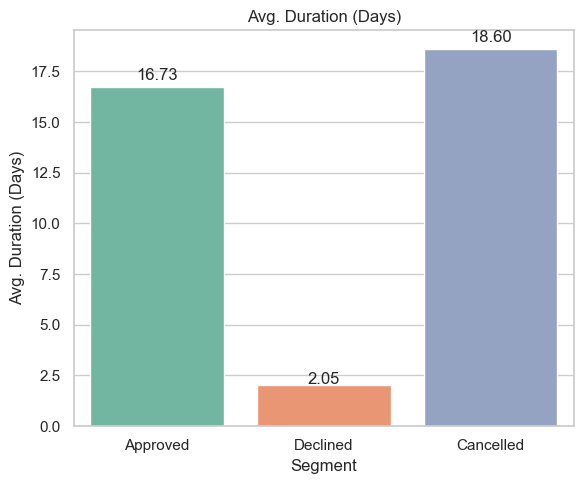

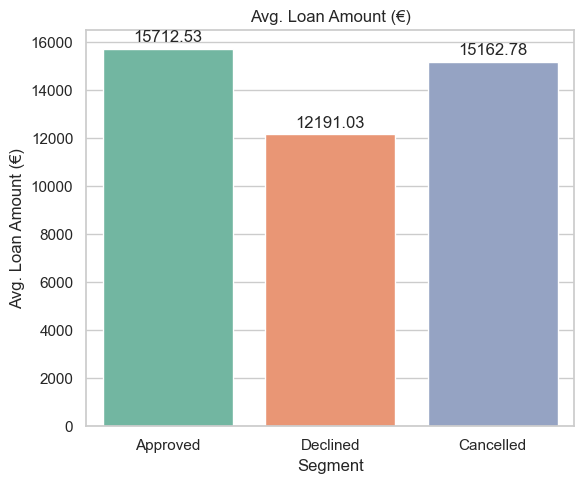

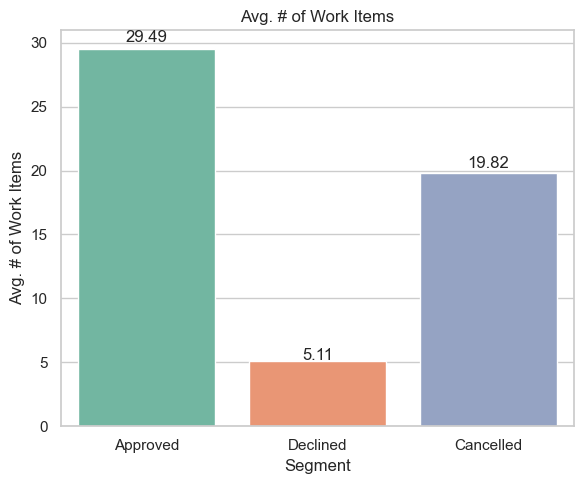

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

metrics = [
    "Avg. Duration (Days)",
    "Avg. Loan Amount (€)",
    "Avg. # of Work Items",
]

for metric in metrics:
    plt.figure(figsize=(6, 5))
    ax = sns.barplot(
        x="Segment", 
        y=metric, 
        data=df_kpi, 
        palette="Set2", 
        hue="Segment", 
        legend=False)
    
    plt.title(metric)
    plt.xlabel("Segment")
    plt.ylabel(metric)

    for index, row in df_kpi.iterrows():
        plt.text(index, row[metric] * 1.02, f"{row[metric]:.2f}", ha='center')

    plt.tight_layout()
    plt.show()

## 5. Direct-Follows Activity Analysis

We analyze the Directly-Follows Graph (DFG) for each segment to understand common process flows and identify rework loops.

### Define DFG Analysis Function

This function discovers the DFG for a log, identifies the most frequent transitions (top N), and specifically highlights self-loops, which are a strong indicator of immediate rework.

In [19]:
from pm4py import discover_dfg


logs = {
    "Approved": log_approved,
    "Declined": log_declined,
    "Cancelled": log_cancelled,
}

_results = []

def print_results(results, segment_name):
    print(f"\n--- Analyzing Top {len(results)} Direct-Follows Relationships for: {segment_name} ---")
    print(f"{'Source':<30} {'->':<4} {'Target':<30} {'Frequency':<10}")
    print("-" * 76)
    for (source, target), freq in results['general']:
        print(f"{source:<30} {'->':<4} {target:<30} {freq:<10}")
    print("\n--- Rework Analysis (Self-Loops) ---")
    print(f"{'Activity':<30} {'->':<4} {'Itself':<30} {'Frequency':<10}")
    print("-" * 76)
    for (_activity, _), freq in results['self_loops']:
            print(f"{_activity:<30} {'->':<4} {_activity:<30} {freq:<10}")


def analyze_direct_follows(_log, top_n=5):
    results = {
        'general': [],
        'self_loops': []
    }
    
    # It returns a dictionary of (source, target) -> frequency.
    dfg, start_activities, end_activities = discover_dfg(_log)
    sorted_dfg = sorted(dfg.items(), key=lambda item: item[1], reverse=True)
    results['general'] = [((source, target), freq) for (source, target), freq in sorted_dfg[:top_n]]
        
    # Specifically look for self-loops which indicate immediate rework
    self_loops = {k: v for k, v in dfg.items() if k[0] == k[1]}
    sorted_loops = sorted(self_loops.items(), key=lambda item: item[1], reverse=True)
    results['self_loops'] = [((_activity, _), freq) for (_activity, _), freq in sorted_loops[:top_n]]
    
    return results

    
for _log_name, _log_value in logs.items():
    result = analyze_direct_follows(_log_value)
    print_results(result, _log_name)
    _results.append(result)
    


--- Analyzing Top 2 Direct-Follows Relationships for: Approved ---
Source                         ->   Target                         Frequency 
----------------------------------------------------------------------------
W_Nabellen incomplete dossiers ->   W_Nabellen incomplete dossiers 12216     
W_Nabellen offertes            ->   W_Nabellen offertes            11637     
W_Completeren aanvraag         ->   W_Completeren aanvraag         6958      
W_Valideren aanvraag           ->   W_Nabellen incomplete dossiers 4529      
W_Valideren aanvraag           ->   W_Valideren aanvraag           4420      

--- Rework Analysis (Self-Loops) ---
Activity                       ->   Itself                         Frequency 
----------------------------------------------------------------------------
W_Nabellen incomplete dossiers ->   W_Nabellen incomplete dossiers 12216     
W_Nabellen offertes            ->   W_Nabellen offertes            11637     
W_Completeren aanvraag         ->   W_

### Visualization for easier understanding

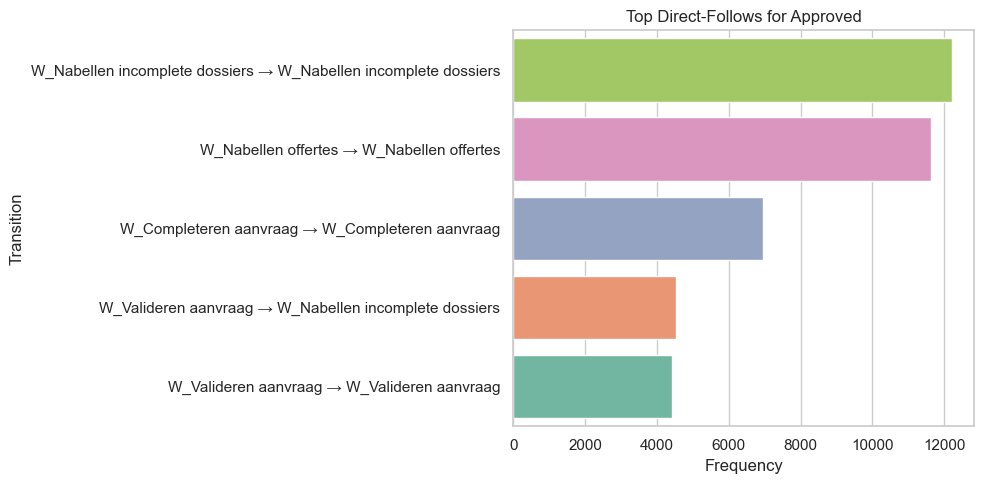

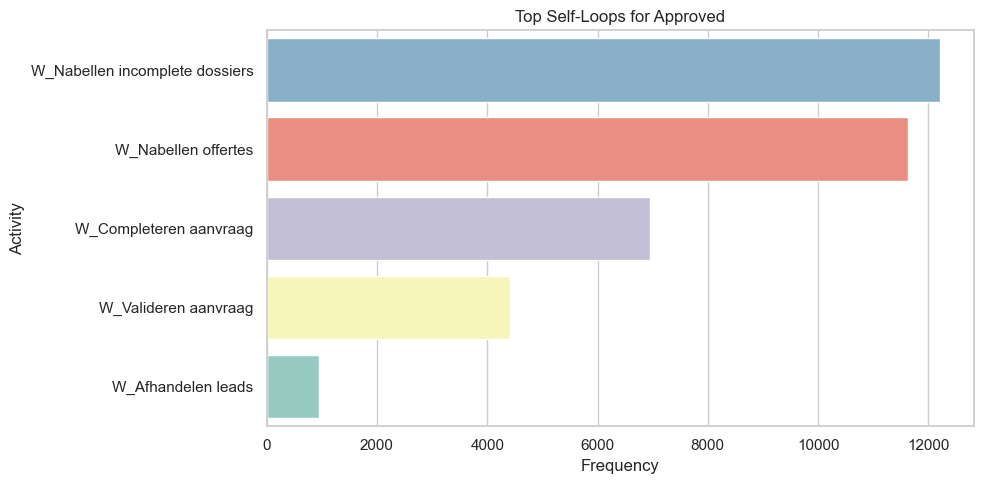

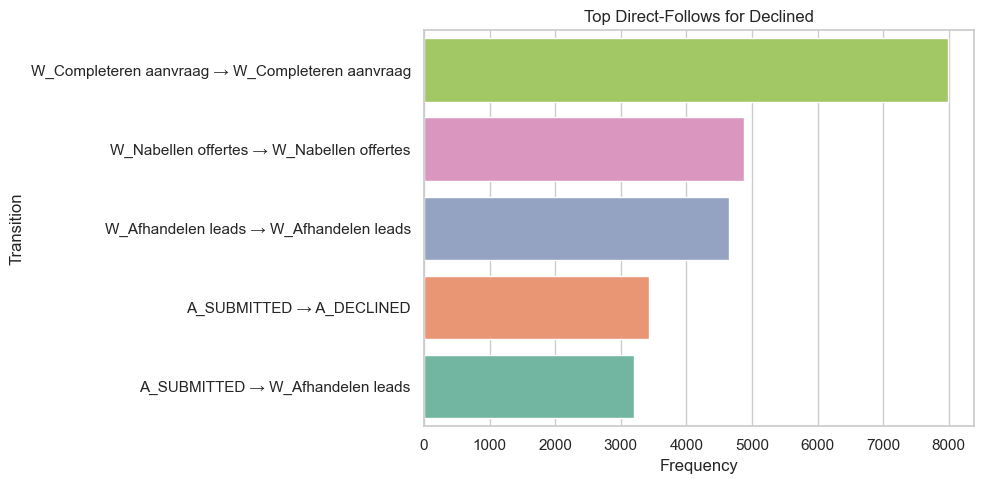

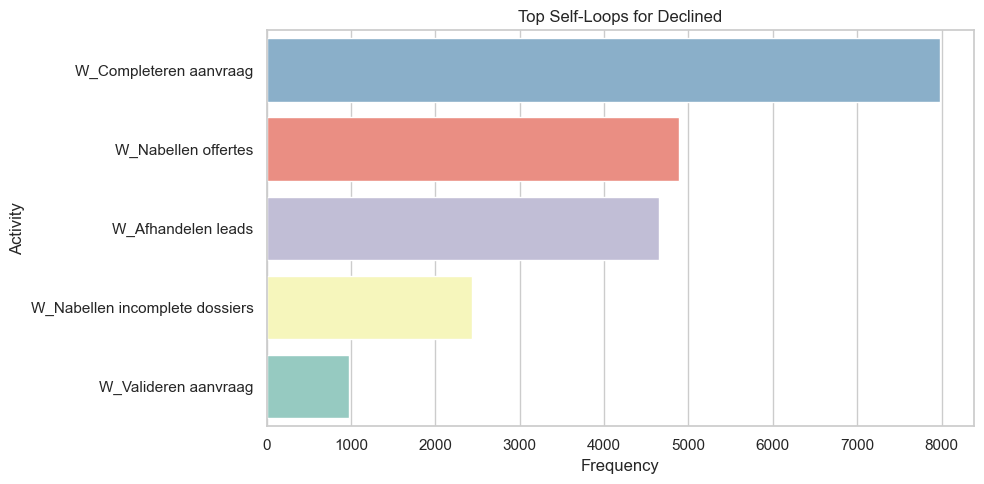

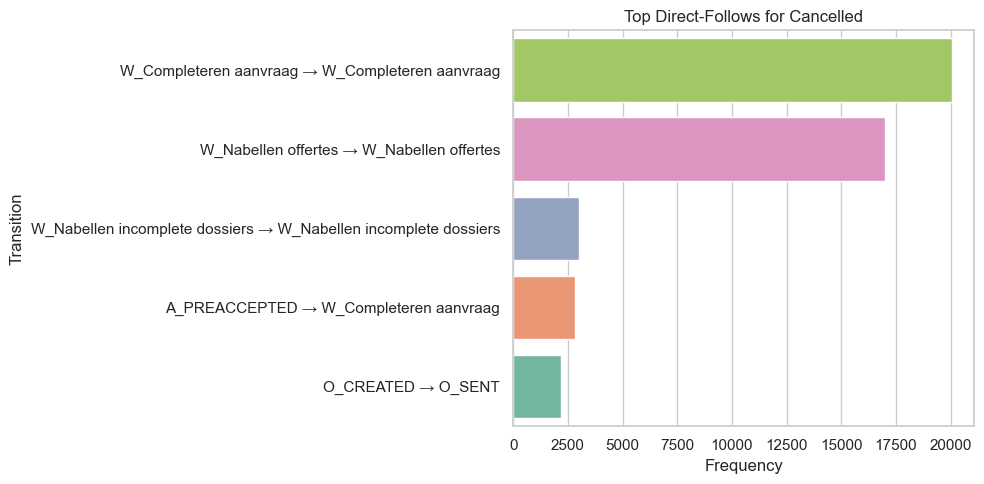

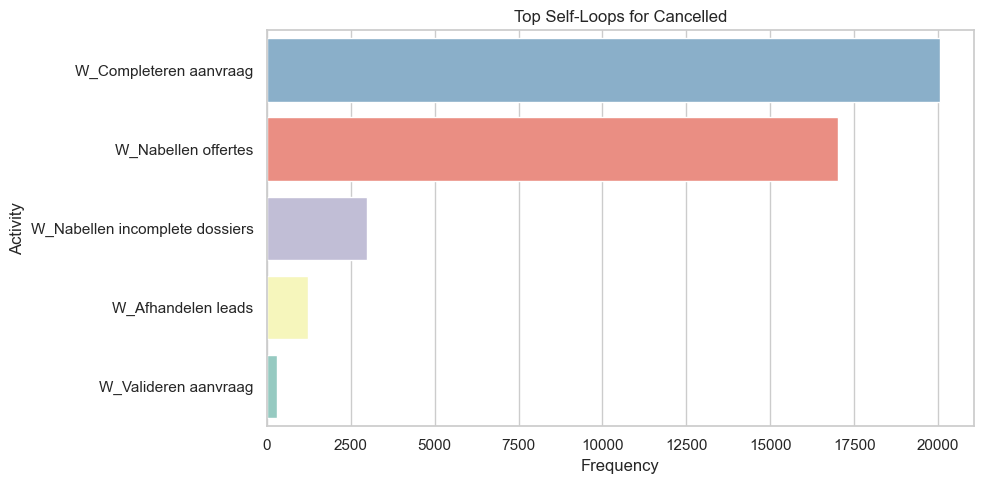

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_results(results, segment_name):
    general_data = results['general']
    if general_data:
        df_general = {
            "Transition": [f"{src} → {tgt}" for (src, tgt), _ in general_data],
            "Frequency": [freq for _, freq in general_data]
        }
        plt.figure(figsize=(10, 5))
        sns.barplot(x="Frequency", y="Transition", data=df_general, palette="Set2", hue="Frequency", legend=False)
        plt.title(f"Top Direct-Follows for {segment_name}")
        plt.xlabel("Frequency")
        plt.ylabel("Transition")
        plt.tight_layout()
        plt.show()

    self_loop_data = results['self_loops']
    if self_loop_data:
        df_loops = {
            "Activity": [_activity for (_activity, _), _ in self_loop_data],
            "Frequency": [freq for _, freq in self_loop_data]
        }
        plt.figure(figsize=(10, 5))
        sns.barplot(x="Frequency", y="Activity", data=df_loops, palette="Set3", hue="Frequency", legend=False)
        plt.title(f"Top Self-Loops for {segment_name}")
        plt.xlabel("Frequency")
        plt.ylabel("Activity")
        plt.tight_layout()
        plt.show()

for i, (_log_name, _log_value) in enumerate(logs.items()):      
    plot_results(_results[i], _log_name)